In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
def mW_to_dBm(pwr_mW):
    return 10*np.log10(pwr_mW)

def dBm_to_mW(pwr_dBm):
    return 10**(pwr_dBm/10)

## Power Stabilization

In [220]:
folder_name = "C:/Users/Ludovico/Desktop/unimib/PhD/Lab tests/Diode responsivity/HP diode 90 GHz/90GHz/2025_02_26_12_56_43_90.0GHz"

In [221]:
filename_stab = folder_name + "/pwr_stabilization.txt"
t_stab,pwr_stab,adc_stab = np.loadtxt(filename_stab,skiprows=1,unpack=True)

Text(0.5, 0.98, 'Power stabilization')

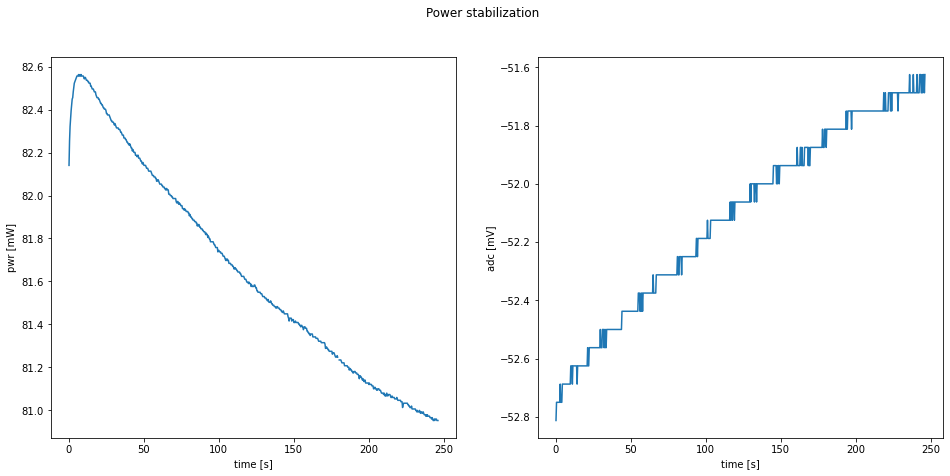

In [222]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(16,7))

ax[0].plot(t_stab,pwr_stab)
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel('pwr [mW]')

ax[1].plot(t_stab,adc_stab)
ax[1].set_xlabel('time [s]')
ax[1].set_ylabel('adc [mV]')

fig.suptitle('Power stabilization')

## Voltage Sweep analysis

In [223]:
filenames = glob.glob(folder_name + "/Voltage_sweep/*V.txt")

# prepare the vectors -------------------------------------------------------------------------
time_vec = np.zeros(len(filenames),dtype=object)
pwr_vec = np.zeros(len(filenames),dtype=object)
adc_vec = np.zeros(len(filenames),dtype=object)
att_tens = np.zeros(len(filenames))

pwr_on_vec = np.zeros(len(filenames),dtype=object)
pwr_off_vec = np.zeros(len(filenames),dtype=object)
adc_on_vec = np.zeros(len(filenames),dtype=object)
adc_off_vec = np.zeros(len(filenames),dtype=object)


# read the data -------------------------------------------------------------------------------
for fn,i in zip(filenames,range(len(filenames))):
    t,pwr,adc = np.loadtxt(fn,skiprows=4,unpack=True)
    time_vec[i] = t
    pwr_vec[i] = pwr
    adc_vec[i] = adc
    att_tens[i] = float(fn.split("\\")[-1].split("V")[0])
    
    pwr_on = []
    pwr_off = []   
    
    adc_on = []
    adc_off = []
    
    if(len(t)>100):
        
        n_rep = int(len(t)/50)
        
        n=0
        while(n<n_rep):
            pwr_off.append(pwr[n*50:(n+1)*50])
            pwr_on.append(pwr[(n+1)*50:(n+2)*50])
            
            adc_off.append(adc[n*50:(n+1)*50])
            adc_on.append(adc[(n+1)*50:(n+2)*50])
            
            n = n+2
            
    pwr_on_vec[i] = pwr_on
    pwr_off_vec[i] = pwr_off
    
    adc_on_vec[i] = adc_on
    adc_off_vec[i] = adc_off
    
# sort for the attenuator tension ----------------------------------------------------------
time_vec = time_vec[np.argsort(att_tens)]
pwr_vec = pwr_vec[np.argsort(att_tens)]
adc_vec = adc_vec[np.argsort(att_tens)]
att_tens = np.sort(att_tens)

# take the median of the adc, the mean of the pwr and see the delta_p and delta_V-------------------------------------
avg_pwr = np.zeros(len(att_tens))
med_adc = np.zeros(len(att_tens))
std_pwr = np.zeros(len(att_tens))
delta_adc = np.zeros(len(att_tens))

for i in range(len(att_tens)):
    
    if(len(pwr_on_vec[i])>0):
        
        
        for pwr_off,pwr_on,adc_off,adc_on in zip(pwr_off_vec[i],pwr_on_vec[i],adc_off_vec[i],adc_on_vec[i]): 
             
            p_off = np.min(pwr_off)
            p_on = np.max(pwr_on)
        
            diff_pwr = p_on-p_off
            
            avg_pwr[i] = np.mean(diff_pwr)
            std_pwr[i] = np.std(diff_pwr)
            
            d_off = np.min(adc_off)
            d_on = np.max(adc_on)
        
            diff_adc = d_on-d_off
            
            med_adc[i] = np.mean(diff_adc)
            delta_adc[i] = np.std(diff_adc)
        
    
    else:
        avg_pwr[i] = np.average(pwr_vec[i][pwr_vec[i]!=-np.inf])
        std_pwr[i] = np.std(pwr_vec[i][pwr_vec[i]!=-np.inf])
        med_adc[i] = np.median(adc_vec[i])
        delta_adc[i] = abs(np.max(adc_vec[i]) - np.min(adc_vec[i]))

Text(0, 0.5, 'adc tension [mV]')

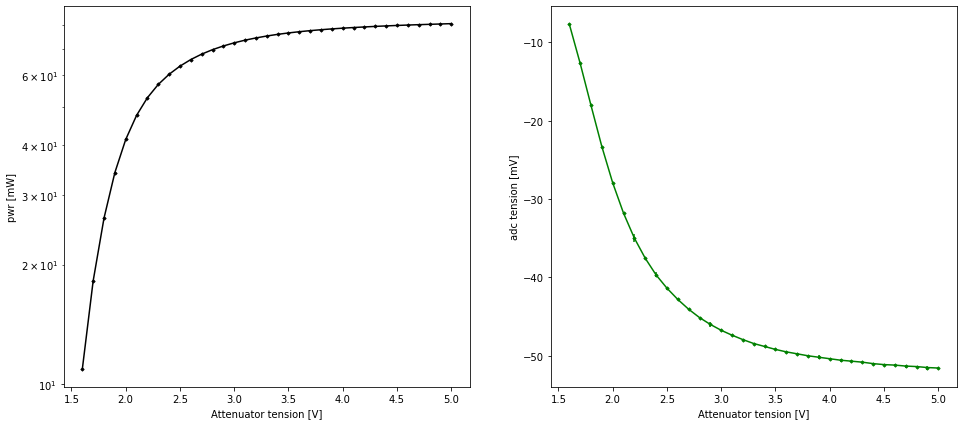

In [224]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(16,7))

ax[0].scatter(att_tens,avg_pwr,marker='D',s=5,color='black')
ax[0].errorbar(att_tens,avg_pwr,yerr=std_pwr,color='black')
ax[0].set_xlabel('Attenuator tension [V]')
ax[0].set_ylabel('pwr [mW]')
ax[0].set_yscale('log')

ax[1].scatter(att_tens,med_adc,color='green',marker='D',s=5)
ax[1].errorbar(att_tens,med_adc,yerr=delta_adc,color='green')
ax[1].set_xlabel('Attenuator tension [V]')
ax[1].set_ylabel('adc tension [mV]')

Text(0.5, 1.0, 'Diode responsivity')

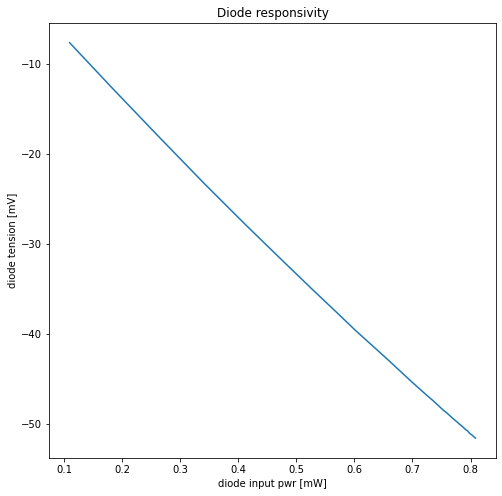

In [227]:
# convert the output power in dBm and correct for the directional coupler:
avg_pwr_dBm = mW_to_dBm(avg_pwr)
pwr_dBm_diode = avg_pwr_dBm - 20 # taking the nominal value from datasheet but the characterization is neeeded.

# move back to mW
pwr_diode = dBm_to_mW(pwr_dBm_diode)

# plot the responsivity:
fig = plt.figure(figsize=(8,8))
plt.plot(pwr_diode,med_adc)
plt.xlabel('diode input pwr [mW]')
plt.ylabel('diode tension [mV]')
plt.title('Diode responsivity')